In [41]:
# general libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import os
from scipy.io import loadmat
import h5py
import importlib
import warnings
from datetime import datetime
import matplotlib.pyplot as plt

# local libraries
import utils

In [42]:
# reload in case of change
importlib.reload(utils)
from utils import get_data_directory
from utils import get_device

In [58]:
# ----------- Config ------------
SEGMENT_LENGTH = 125000  # 1 second @ 24kHz was 125 with a single fc layer performed relatively well
BATCH_SIZE = 16
EMBEDDING_DIM = 128
# LEARNING_RATE = 2e-5 # 1e4 had good results
LEARNING_RATE = 1e-3 # 1e-4 had good results
EPOCHS = 500
LOG_DIR = "runs/siamese_lfp3"
RUN_SIMULATION_DATA = False 
RUN_REAL_DATA = not RUN_SIMULATION_DATA
SIMULATION_DATA_SEPARABLE = True

In [59]:
# ----------- Data Preparation ------------
def segment_data(data, segment_length):
    num_segments = len(data) // segment_length
    segments = np.array(np.split(data[:num_segments * segment_length], num_segments))
    np.random.shuffle(segments)
    return segments


# def create_pairs(gpi_segments, stn_segments):
#     pairs = []
#     labels = []

#     # GPi-GPi (label 0)
#     for i in range(len(gpi_segments) - 1):
#         pairs.append((gpi_segments[i], gpi_segments[i+1]))
#         labels.append(0)

#     # STN-STN (label 0)
#     for i in range(len(stn_segments) - 1):
#         pairs.append((stn_segments[i], stn_segments[i+1]))
#         labels.append(0)

#     # GPi-STN (label 1)
#     for i in range(min(len(gpi_segments), len(stn_segments))):
#         pairs.append((gpi_segments[i], stn_segments[i]))
#         labels.append(1)

#     ratio_similar = labels.count(0) / len(labels)
#     print(f"Similarity label ratio: {ratio_similar:.2f} similar (label 0), {1 - ratio_similar:.2f} dissimilar (label 1)")

#     return pairs, labels

def create_pairs(gpi_segments, stn_segments, max_dataset_size):
    # GPi-GPi (label 0)
    gpi_gpi_pairs = [(gpi_segments[i], gpi_segments[i+1]) for i in range(len(gpi_segments) - 1)]
    gpi_gpi_pairs.extend([(gpi_segments[i], gpi_segments[i+2]) for i in range(len(gpi_segments) - 2)])
    gpi_gpi_pairs.extend([(gpi_segments[i], gpi_segments[i+3]) for i in range(len(gpi_segments) - 3)])
    gpi_gpi_pairs.extend([(gpi_segments[i], gpi_segments[i+4]) for i in range(len(gpi_segments) - 4)])
    gpi_gpi_labels = [0] * len(gpi_gpi_pairs)

    # STN-STN (label 0)
    stn_stn_pairs = [(stn_segments[i], stn_segments[i+1]) for i in range(len(stn_segments) - 1)]
    stn_stn_pairs.extend([(stn_segments[i], stn_segments[i+2]) for i in range(len(stn_segments) - 2)])
    stn_stn_pairs.extend([(stn_segments[i], stn_segments[i+3]) for i in range(len(stn_segments) - 3)])
    stn_stn_pairs.extend([(stn_segments[i], stn_segments[i+4]) for i in range(len(stn_segments) - 4)])
    stn_stn_labels = [0] * len(stn_stn_pairs)

    # GPi-STN (label 1)
    gpi_stn_pairs = [(gpi_segments[i], stn_segments[i]) for i in range(min(len(gpi_segments), len(stn_segments)))]
    gpi_stn_pairs.extend([(gpi_segments[i], stn_segments[i+1]) for i in range(min(len(gpi_segments), len(stn_segments))-1)])
    gpi_stn_pairs.extend([(gpi_segments[i+1], stn_segments[i]) for i in range(min(len(gpi_segments), len(stn_segments))-1)])
    gpi_stn_pairs.extend([(gpi_segments[i], stn_segments[i+2]) for i in range(min(len(gpi_segments), len(stn_segments))-2)])
    gpi_stn_labels = [1] * len(gpi_stn_pairs)

    # Combine similar pairs
    similar_pairs = gpi_gpi_pairs + stn_stn_pairs
    similar_labels = gpi_gpi_labels + stn_stn_labels
    similar_labels = [0] * len(similar_pairs)

    combined_similar = list(zip(similar_pairs, similar_labels))
    np.random.shuffle(combined_similar)
    similar_pairs, similar_labels = zip(*combined_similar)
    similar_pairs, similar_labels = list(similar_pairs), list(similar_labels)

    # Balance both classes
    min_len = min(len(similar_pairs), len(gpi_stn_pairs), max_dataset_size)
    balanced_pairs = similar_pairs[:min_len] + gpi_stn_pairs[:min_len]
    balanced_labels = similar_labels[:min_len] + gpi_stn_labels[:min_len]

    ratio_similar = balanced_labels.count(0) / len(balanced_labels)
    print(f"Balanced similarity label ratio: {ratio_similar:.2f} similar (label 0), {1 - ratio_similar:.2f} dissimilar (label 1)")

    return balanced_pairs, balanced_labels


class LFPDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        x1, x2 = self.pairs[idx]
        x1 = torch.tensor(x1, dtype=torch.float32).unsqueeze(0)
        x2 = torch.tensor(x2, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x1, x2, label

In [60]:
# ----------- Model Definition ------------
class CNNEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(CNNEncoder, self).__init__()
        # self.layers = nn.ModuleList([
        #     nn.Dropout(0.3),
        #     nn.Conv1d(1, 4, kernel_size=16, stride=2, padding=8),
        #     nn.BatchNorm1d(4),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Conv1d(4, 8, kernel_size=32, stride=2, padding=16),
        #     nn.BatchNorm1d(8),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Conv1d(8, 16, kernel_size=64, stride=2, padding=32),
        #     nn.BatchNorm1d(16),
        #     nn.ReLU(),
        #     # nn.Dropout(0.1),
        #     nn.Conv1d(16, 32, kernel_size=128, stride=2, padding=64),
        #     nn.BatchNorm1d(32),
        #     nn.ReLU(),
        #     # nn.Dropout(0.1),
        #     nn.Conv1d(32, 64, kernel_size=256, stride=2, padding=128),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(),
        #     # nn.Dropout(0.1),
        #     nn.Conv1d(64, 64, kernel_size=512, stride=2, padding=256),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.AdaptiveAvgPool1d(1)
        # ])

        self.layers = nn.ModuleList([
            nn.Dropout(0.3),
            nn.Conv1d(1, 32, kernel_size=32, stride=8, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(32, 64, kernel_size=32, stride=2, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(64, 64, kernel_size=16, stride=2, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(64, 64, kernel_size=8, stride=2, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(64, 64, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(64, 64, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.AdaptiveAvgPool1d(1)
        ])
        self.fc = nn.Sequential(
            nn.Linear(64, embedding_dim),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(embedding_dim, embedding_dim//2),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(embedding_dim//2,embedding_dim//4)  # Final layer maps to embedding space
        )
        # self.fc = nn.Linear(64, embedding_dim) # achived 58.8 percent testing accuracy

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def embed(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


def count_parameters(model):
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total:,}\n")
    print("Trainable parameters by layer:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:50} {param.numel():,}")


def print_model_summary(model, train_loader, device):
    print("===== Sample Forward Pass Shape Info =====")
    x_sample = next(iter(train_loader))[0].to(device)
    model.encoder(x_sample)
    print("\nModel Summary:\n")
    print(model)
    count_parameters(model)


class SiameseNet(nn.Module):
    def __init__(self, embedding_dim):
        super(SiameseNet, self).__init__()
        self.encoder = CNNEncoder(embedding_dim)

    def forward(self, x1, x2):
        embed1 = self.encoder(x1)
        embed2 = self.encoder(x2)
        distance = F.pairwise_distance(embed1, embed2)
        # distance = 1 - F.cosine_similarity(embed1, embed2)
        return distance 



In [61]:

# ----------- Training Loop ------------
def train(model, dataloader, optimizer, criterion, device, writer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (x1, x2, label) in enumerate(dataloader):
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(x1, x2)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        preds = (output > 0.5).float()
        correct += (preds == label).sum()
        total += label.size(0)
        if i == 0:
            print("Train Preds:", preds[:10])
            print("Train Labels:", label[:10])
        writer.add_scalar('Train/Batch_Loss', loss.item(), epoch * len(dataloader) + i)
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    print(f"Epoch {epoch+1} Train Accuracy: {accuracy:.4f}")
    writer.add_scalar('Train/Epoch_Loss', avg_loss, epoch)
    writer.add_scalar('Train/Accuracy', accuracy, epoch)
    return avg_loss


def evaluate(model, dataloader, criterion, device, writer, epoch):
    model.eval() # disable drop outs and does batch normalization in validation mode
    total_loss = 0.0
    correct = 0
    total = 0
    tcounter = 0
    with torch.no_grad():
        for x1, x2, label in dataloader:
            tcounter = tcounter + 1
            x1, x2, label = x1.to(device), x2.to(device), label.to(device)
            output = model(x1, x2)
            loss = criterion(output, label)
            total_loss += loss.item()
            preds = (output > 0.5).float()  # Same for both train and test
            correct += (preds == label).sum().item()
            total += label.size(0)
            if tcounter == 1:
                print("Test Preds:", preds[0:15])
                print("Test Labels:", label[0:15])
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    print(f"Epoch {epoch+1} Test Accuracy: {accuracy:.4f}")
    writer.add_scalar('Test/Epoch_Loss', avg_loss, epoch)
    writer.add_scalar('Test/Accuracy', accuracy, epoch)
    return avg_loss

def training_validate_loop(model, train_loader, test_loader, device, run_dir, epochs):
     
    # TensorBoard setup
    os.makedirs(run_dir, exist_ok=True)
    writer = SummaryWriter(run_dir)

    # optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    criterion = contrastive_loss
    # criterion = nn.BCEWithLogitsLoss()


    model_save_path = run_dir + "\\full_siamese_model_best.pt"
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 20

    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device, writer, epoch)
        validate_loss = evaluate(model, test_loader, criterion, device, writer, epoch)
        scheduler.step(validate_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} - LR: {current_lr:.10f} - Train Loss: {train_loss:.4f} - Test Loss: {validate_loss:.4f}")
        writer.add_scalar('LearningRate', current_lr, epoch)

        # --- Early Stopping & Checkpoint ---
        if validate_loss < best_val_loss:
            best_val_loss = validate_loss
            torch.save(model, model_save_path)
            print(f" New best model saved at epoch {epoch+1}")
            epochs_no_improve = 0

        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f" Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                break
    
    writer.close()
    
    return torch.load(model_save_path)



def contrastive_loss(distances, labels, margin=1.0):
        labels = labels.float()
        loss_similar = (1 - labels) * distances.pow(2)
        loss_dissimilar = labels * F.relu(margin - distances).pow(2)
        return torch.mean(loss_similar + loss_dissimilar)

In [62]:
# visualization 
def extract_embeddings(model, data_segments, label, device):
    model.eval()
    all_embeddings = []
    with torch.no_grad():
        for segment in data_segments:
            x = torch.tensor(segment, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, T)
            embedding = model.embed(x).cpu().numpy().squeeze()
            all_embeddings.append((embedding, label))
    return all_embeddings

def visualize(embeddings_with_labels):
    embeddings = np.array([e for e, _ in embeddings_with_labels])
    labels = np.array([l for _, l in embeddings_with_labels])

    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f"{'GPi' if label == 0 else 'STN'}", alpha=0.7)

    plt.legend()
    plt.title("Functional Embedding Space")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.show()


In [63]:
# utils
def create_timestamped_logdir(base_dir="runs"):
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    log_dir = os.path.join(base_dir, f"siamese_{timestamp}")
    return log_dir

In [ ]:
# # ----------- Run Pipeline ------------
# def main():
    
# pipeline:
# get data (simulation or real)
# preprocessing normalize data
# process data for training
# train data (alot of parameters )
# visualzied points whether its on validatoin or training set or test set

# Get/generate data
if RUN_SIMULATION_DATA:
    # Generate synthetic LFP-like signals with sinusoids + noise
    if SIMULATION_DATA_SEPARABLE == False:
        fs = 24414
        duration_sec = 60 * 10
        t = np.linspace(0, duration_sec, fs * duration_sec, endpoint=False)
        gpi_signal = np.sin(2 * np.pi * 10 * t)*0.001  # 10 Hz sinusoid
        stn_signal = np.sin(2 * np.pi * 23 * t)*0.001  # 23 Hz sinusoid
        GPiData = gpi_signal + 0.0005 * np.random.randn(len(t))
        STNData = stn_signal + 0.0005 * np.random.randn(len(t))

    # Simulate random LFP-like signals which are not separable 
    else :
        GPiData = np.random.randn(24000 * 60 * 5)*0.001  # 2 minutes of data
        STNData = np.random.randn(24000 * 60 * 5)*0.001
    
else: 
    # load real data
    # for Sina's PC: F:\Python Projects\data\period9
    # for shared PC: D:\Sina\Data\period9\microSTN_L_3_CommonFiltered.mat
    dataPath = get_data_directory()
    with h5py.File(dataPath+ "microGPi1_L_4_CommonFiltered.mat", "r") as f:
        raw_gpi = np.array(f["data"]).squeeze()
        fs = int(np.array(f["fs"]).squeeze())
    with h5py.File(dataPath + "microSTN_L_3_CommonFiltered.mat", "r") as f:
        raw_stn = np.array(f["data"]).squeeze()  # replace with your actual filename

    # normalization 
    GPiData = (raw_gpi - np.mean(raw_gpi)) / np.std(raw_gpi)
    STNData = (raw_stn - np.mean(raw_stn)) / np.std(raw_stn)


# Print dataset shape and sizes
print("===== Dataset Information =====")

# Segment
gpi_segments = segment_data(GPiData, SEGMENT_LENGTH)
stn_segments = segment_data(STNData, SEGMENT_LENGTH)
max_dataset_size = 5000
pairs, labels = create_pairs(gpi_segments, stn_segments, max_dataset_size)

# Split data
train_pairs, test_pairs, train_labels, test_labels = train_test_split( pairs, labels, test_size=0.2, stratify=labels, shuffle=True, random_state=42)

# Dataloaders
train_ds = LFPDataset(train_pairs, train_labels)
test_ds = LFPDataset(test_pairs, test_labels)
print(f"Train set: {len(train_ds)} pairs")
print(f"Test set: {len(test_ds)} pairs")
print(f"Batch size: {BATCH_SIZE}")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
print(f"Running on " + "Real data" if RUN_REAL_DATA else "Simulated data")
print("===== Training Input Shape Info =====")
for x1, x2, _ in train_loader:
    print(f"Train input shapes: x1: {x1.shape}, x2: {x2.shape}")
    break
print("===== Testing Input Shape Info =====")
for x1, x2, _ in test_loader:
    print(f"Test input shapes: x1: {x1.shape}, x2: {x2.shape}\n\n")
    break


# Check GPU
device = get_device()
print(f" Using {device}")

# Model setup
model = SiameseNet(embedding_dim=EMBEDDING_DIM).to(device)
print_model_summary(model, train_loader, device)

run_name = create_timestamped_logdir() + "" #add name if you want
trained_model = training_validate_loop(model, train_loader, test_loader, device, run_name, EPOCHS)



===== Dataset Information =====
Balanced similarity label ratio: 0.50 similar (label 0), 0.50 dissimilar (label 1)
Train set: 4736 pairs
Test set: 1184 pairs
Batch size: 16
Running on Real data
===== Training Input Shape Info =====
Train input shapes: x1: torch.Size([16, 1, 125000]), x2: torch.Size([16, 1, 125000])
===== Testing Input Shape Info =====
Test input shapes: x1: torch.Size([16, 1, 125000]), x2: torch.Size([16, 1, 125000])


 Using cuda
===== Sample Forward Pass Shape Info =====

Model Summary:

SiameseNet(
  (encoder): CNNEncoder(
    (layers): ModuleList(
      (0): Dropout(p=0.3, inplace=False)
      (1): Conv1d(1, 32, kernel_size=(32,), stride=(8,))
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(32, 64, kernel_size=(32,), stride=(2,))
      (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8):

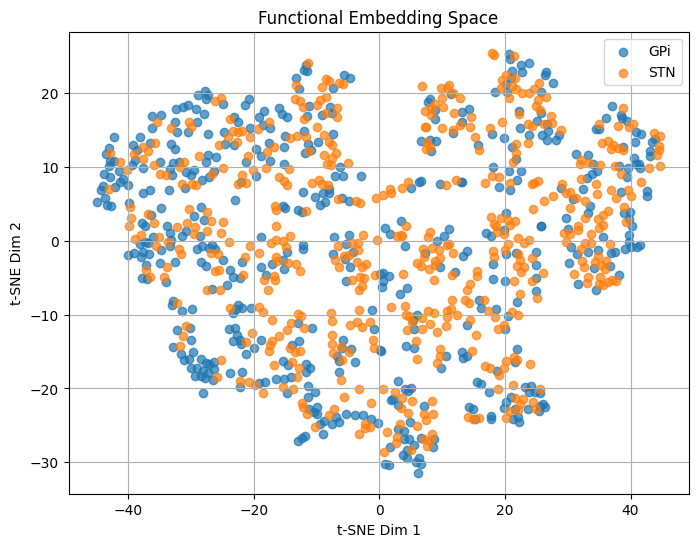

In [ ]:
# visualize_embeddings.py


# model = SiameseNet(embedding_dim=EMBEDDING_DIM).to(device)
# model.load_state_dict(torch.load("only weights_siamese_model.pt", map_location=device))
trained_model= torch.load("runs/siamese_2025-04-22_18-20/full_siamese_model_best.pt", weights_only=False)
trained_model.eval()
encoder_model = trained_model.encoder
encoder_model.eval()



dataPath = get_data_directory()
with h5py.File(dataPath+ "microGPi1_L_5_CommonFiltered.mat", "r") as f:
    raw_gpi = np.array(f["data"]).squeeze()
    fs = int(np.array(f["fs"]).squeeze())
with h5py.File(dataPath + "microSTN_L_2_CommonFiltered.mat", "r") as f:
    raw_stn = np.array(f["data"]).squeeze()  # replace with your actual filename

# normalization 
gpi_data = (raw_gpi - np.mean(raw_gpi)) / np.std(raw_gpi)
stn_data = (raw_stn - np.mean(raw_stn)) / np.std(raw_stn)

gpi_segments = segment_data(gpi_data, SEGMENT_LENGTH)[:500]  # take first 100 segments
stn_segments = segment_data(stn_data, SEGMENT_LENGTH)[:500]

gpi_embeddings = extract_embeddings(encoder_model, gpi_segments, label=0, device=device)
stn_embeddings = extract_embeddings(encoder_model, stn_segments, label=1, device=device)

all_embeddings = gpi_embeddings + stn_embeddings
visualize(all_embeddings)




In [ ]:
# # Run
# if __name__ == "__main__":
#     model = main()x
    

===== Dataset Information =====
Balanced similarity label ratio: 0.50 similar (label 0), 0.50 dissimilar (label 1)
Train set: 4736 pairs
Test set: 1184 pairs
Batch size: 16
Running on Real data


===== Training Input Shape Info =====
Train input shapes: x1: torch.Size([16, 1, 125000]), x2: torch.Size([16, 1, 125000])
===== Testing Input Shape Info =====
Test input shapes: x1: torch.Size([16, 1, 125000]), x2: torch.Size([16, 1, 125000])
 Using cpu
===== Sample Forward Pass Shape Info =====

Model Summary:

SiameseNet(
  (encoder): CNNEncoder(
    (layers): ModuleList(
      (0): Dropout(p=0.3, inplace=False)
      (1): Conv1d(1, 32, kernel_size=(32,), stride=(8,))
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(32, 64, kernel_size=(32,), stride=(2,))
      (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): 

f:\Python Projects\NIPS2025\utils.py:20: RuntimeWarning: ⚠️ CUDA is not available. The model will run on CPU, which may be slower.
  warnings.warn("⚠️ CUDA is not available. The model will run on CPU, which may be slower.", RuntimeWarning)


Train Preds: tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
Train Labels: tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 1.])
Epoch 1 Train Accuracy: 0.5239
Test Preds: tensor([0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.])
Test Labels: tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.])
Epoch 1 Test Accuracy: 0.8066
Epoch 1 - LR: 0.001000 - Train Loss: 0.2946 - Test Loss: 0.3603
Train Preds: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
Train Labels: tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 1.])
Epoch 2 Train Accuracy: 0.5416
Test Preds: tensor([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.])
Test Labels: tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.])
Epoch 2 Test Accuracy: 0.6242
Epoch 2 - LR: 0.001000 - Train Loss: 0.2872 - Test Loss: 0.4634
Train Preds: tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])
Train Labels: tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
Epoch 3 Train Accuracy: 0.5598
Test Preds: tensor

KeyboardInterrupt: 

In [ ]:
# Run
if __name__ == "__main__":
    model = main()

===== Dataset Information =====
Balanced similarity label ratio: 0.50 similar (label 0), 0.50 dissimilar (label 1)
Train set: 1185 pairs
Test set: 297 pairs
Batch size: 16
cpu
===== Sample Forward Pass Shape Info =====

Model Summary:

SiameseNet(
  (encoder): CNNEncoder(
    (layers): ModuleList(
      (0): Dropout(p=0.3, inplace=False)
      (1): Conv1d(1, 32, kernel_size=(32,), stride=(8,))
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(32, 64, kernel_size=(32,), stride=(2,))
      (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Dropout(p=0.5, inplace=False)
      (9): Conv1d(64, 64, kernel_size=(16,), stride=(2,))
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Dropout(p=0.5, inplace=False)
      (13): Conv1d(64, 64, kernel_

In [ ]:
# to do: 
# add more dense layers maybe it can help with non linearity of the map add 3 fully connected layers
# learning rate scheduler